In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


## Dataset
- **Source:** `CJA07.20251204134405.csv` contains annual crime statistics for Garda stations in Ireland from 2003 to 2024.
- **Link to the dataset:** [data.gov.ie - Crime Data](https://data.gov.ie/dataset/cja07-recorded-crime-incidents/resource/310df8ca-6b19-4328-9d50-5620fbece3e2)
- **Columns:** Key columns include `Garda Station`, `Year`, `Type of Offence`, and `VALUE` represents number of incidents.

In [5]:
# Load the Dataset


# Link to the dataset: https://data.gov.ie/dataset/cja07-recorded-crime-incidents/resource/310df8ca-6b19-4328-9d50-5620fbece3e2

file_path = '../data/CJA07.20251204134405.csv'
df = pd.read_csv(file_path)

print("Raw Data Shape:", df.shape)

print("Year Range:", df['Year'].min(), "-", df['Year'].max())
print("Number of Garda Stations:", df['Garda Station'].nunique())

Raw Data Shape: (148896, 10)
Year Range: 2003 - 2024
Number of Garda Stations: 564


In [6]:
# First 5 rows of the dataset
df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C03037V03742,Garda Station,C02480V03003,Type of Offence,UNIT,VALUE
0,CJA07,Recorded crime incidents,2003,2003,35301,"35301 Abbeyfeale, Limerick Division",3,"Attempts/threats to murder, assaults, harassme...",Number,18.0
1,CJA07,Recorded crime incidents,2003,2003,35301,"35301 Abbeyfeale, Limerick Division",4,Dangerous or negligent acts (04),Number,14.0
2,CJA07,Recorded crime incidents,2003,2003,35301,"35301 Abbeyfeale, Limerick Division",5,Kidnapping and related offences (05),Number,0.0
3,CJA07,Recorded crime incidents,2003,2003,35301,"35301 Abbeyfeale, Limerick Division",6,"Robbery, extortion and hijacking offences (06)",Number,0.0
4,CJA07,Recorded crime incidents,2003,2003,35301,"35301 Abbeyfeale, Limerick Division",7,Burglary and related offences (07),Number,27.0


Preprocessing Steps:

1. Pivoted the data so that each row represents a unique (Region, Year) combination, and columns represent different offence types.


In [7]:
# Since the data is around Garda Stations and Types of Offence from Each Garda Station,
# We can use this data to classify the safety levels of each garda station
# Hence we are modifying the structure of the dataset to pivot around Garda Stations and Types of Offence

df_pivot = df.pivot_table(
    index=['Garda Station', 'Year'],
    columns='Type of Offence',
    values='VALUE',
    aggfunc='sum'
).reset_index()

df_pivot.head()

Type of Offence,Garda Station,Year,"Attempts/threats to murder, assaults, harassments and related offences (03)",Burglary and related offences (07),Controlled drug offences (10),Damage to property and to the environment offences (12),Dangerous or negligent acts (04),"Fraud, deception and related offences (09)",Kidnapping and related offences (05),"Offences against government, justice procedures and organisation of crime (15)",Public order and other social code offences (13),"Robbery, extortion and hijacking offences (06)",Theft and related offences (08),Weapons and explosives offences (11)
0,"11101 Bailieboro, Cavan/Monaghan Division",2003,28.0,27.0,16.0,53.0,21.0,8.0,0.0,5.0,56.0,0.0,47.0,1.0
1,"11101 Bailieboro, Cavan/Monaghan Division",2004,45.0,13.0,7.0,42.0,22.0,9.0,0.0,9.0,89.0,1.0,34.0,1.0
2,"11101 Bailieboro, Cavan/Monaghan Division",2005,32.0,16.0,13.0,38.0,36.0,4.0,0.0,3.0,52.0,0.0,44.0,1.0
3,"11101 Bailieboro, Cavan/Monaghan Division",2006,57.0,15.0,13.0,48.0,43.0,3.0,0.0,14.0,104.0,1.0,60.0,3.0
4,"11101 Bailieboro, Cavan/Monaghan Division",2007,35.0,25.0,9.0,42.0,52.0,10.0,0.0,9.0,96.0,2.0,48.0,2.0


2. Handling Missing
- Verified that there is no missing data in the dataset, Hence no imputation was required.

In [8]:
# This dataset dows not contain any null values 
# hence imputation is not required
df_pivot.isnull().sum()

Type of Offence
Garda Station                                                                     0
Year                                                                              0
Attempts/threats to murder, assaults, harassments and related offences (03)       0
Burglary and related offences (07)                                                0
Controlled drug offences (10)                                                     0
Damage to property and to the environment  offences (12)                          0
Dangerous or negligent acts (04)                                                  0
Fraud, deception and related offences (09)                                        0
Kidnapping and related offences (05)                                              0
Offences against government, justice procedures and organisation of crime (15)    0
Public order and other social code offences (13)                                  0
Robbery, extortion and hijacking offences (06)              

3. Removing numbers from column names to make them more understandable

In [9]:
# Column names before cleaning
print("Column names before cleaning:", df_pivot.columns)

# Cleaning Column names
df_pivot.columns = [col.split('(')[0].strip() if isinstance(col, str) else col for col in df_pivot.columns]
print()
# Column names after cleaning
print("Column names after cleaning:", df_pivot.columns)

Column names before cleaning: Index(['Garda Station', 'Year',
       'Attempts/threats to murder, assaults, harassments and related offences (03)',
       'Burglary and related offences (07)', 'Controlled drug offences (10)',
       'Damage to property and to the environment  offences (12)',
       'Dangerous or negligent acts (04)',
       'Fraud, deception and related offences (09)',
       'Kidnapping and related offences (05)',
       'Offences against government, justice procedures and organisation of crime (15)',
       'Public order and other social code offences (13)',
       'Robbery, extortion and hijacking offences (06)',
       'Theft and related offences (08)',
       'Weapons and explosives offences (11)'],
      dtype='object', name='Type of Offence')

Column names after cleaning: Index(['Garda Station', 'Year',
       'Attempts/threats to murder, assaults, harassments and related offences',
       'Burglary and related offences', 'Controlled drug offences',
       'Dama

Engineered a new column called 'Total Crime Rate' by summing all offence rates.

In [10]:
# Get offence columns
offence_cols = [col for col in df_pivot.columns if col not in ['Garda Station', 'Year']]

# Calculate total crime for each station-year
df_pivot['Total_Crime'] = df_pivot[offence_cols].sum(axis=1)

print("Pivoted Data Shape:", df_pivot.shape)
print("Offence columns:", len(offence_cols))
df_pivot.head()

Pivoted Data Shape: (12408, 15)
Offence columns: 12


,Garda Station,Year,"Attempts/threats to murder, assaults, harassments and related offences",Burglary and related offences,Controlled drug offences,Damage to property and to the environment offences,Dangerous or negligent acts,"Fraud, deception and related offences",Kidnapping and related offences,"Offences against government, justice procedures and organisation of crime",Public order and other social code offences,"Robbery, extortion and hijacking offences",Theft and related offences,Weapons and explosives offences,Total_Crime
0,"11101 Bailieboro, Cavan/Monaghan Division",2003,28.0,27.0,16.0,53.0,21.0,8.0,0.0,5.0,56.0,0.0,47.0,1.0,262.0
1,"11101 Bailieboro, Cavan/Monaghan Division",2004,45.0,13.0,7.0,42.0,22.0,9.0,0.0,9.0,89.0,1.0,34.0,1.0,272.0
2,"11101 Bailieboro, Cavan/Monaghan Division",2005,32.0,16.0,13.0,38.0,36.0,4.0,0.0,3.0,52.0,0.0,44.0,1.0,239.0
3,"11101 Bailieboro, Cavan/Monaghan Division",2006,57.0,15.0,13.0,48.0,43.0,3.0,0.0,14.0,104.0,1.0,60.0,3.0,361.0
4,"11101 Bailieboro, Cavan/Monaghan Division",2007,35.0,25.0,9.0,42.0,52.0,10.0,0.0,9.0,96.0,2.0,48.0,2.0,330.0


Crime statistics aggregated by station and by year.

Implementation of lagging features to leverage crime data of the current year to predict the future level of safety.

Developed a target variable called "Safety_Level" by discretizing the total crime rate of next year into "Safe", "Moderately Safe", and "Unsafe" based on quantile binning.


In [ ]:
# Use Year N's crime data to predict Year N+1's safety level

# Sort by station and year
df_pivot = df_pivot.sort_values(['Garda Station', 'Year'])

# Creating next year's total crime numbers. This is our target.
df_pivot['Next_Year_Crime'] = df_pivot.groupby('Garda Station')['Total_Crime'].shift(-1)

# Remove rows where next year data is missing (last year for each station)
df_lagged = df_pivot.dropna(subset=['Next_Year_Crime']).copy()

print(f"Original samples: {len(df_pivot)}")
print(f"After lagging (losing last year per station): {len(df_lagged)}")

# Create Safety Level target based on NEXT year's crime
df_lagged['Safety_Level'] = pd.qcut(
    df_lagged['Next_Year_Crime'], 
    q=3, 
    labels=['Safe', 'Moderately Safe', 'Unsafe']
)

print("\n=== Target Variable Distribution (Next Year's Safety) ===")
print(df_lagged['Safety_Level'].value_counts())

Original samples: 12408
After lagging (losing last year per station): 11844

=== Target Variable Distribution (Next Year's Safety) ===
Safety_Level
Safe               3982
Unsafe             3946
Moderately Safe    3916
Name: count, dtype: int64


In [12]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11844 entries, 0 to 12406
Data columns (total 17 columns):
 #   Column                                                                     Non-Null Count  Dtype   
---  ------                                                                     --------------  -----   
 0   Garda Station                                                              11844 non-null  object  
 1   Year                                                                       11844 non-null  int64   
 2   Attempts/threats to murder, assaults, harassments and related offences     11844 non-null  float64 
 3   Burglary and related offences                                              11844 non-null  float64 
 4   Controlled drug offences                                                   11844 non-null  float64 
 5   Damage to property and to the environment  offences                        11844 non-null  float64 
 6   Dangerous or negligent acts                        

Extracted division information from station names.

In [ ]:
# Extraction of Division from Station name
df_lagged['Division'] = df_lagged['Garda Station'].apply(
    lambda x: x.split(', ')[-1].replace(' Division', '') if ', ' in str(x) else 'Unknown'
)

Final Dataset

In [15]:
print(f"Shape: {df_lagged.shape}")
print(f"Stations: {df_lagged['Garda Station'].nunique()}")
print(f"Years: {df_lagged['Year'].min()} - {df_lagged['Year'].max()}")
print(f"\nFeatures (current year): {offence_cols}")
print(f"Target: Next year's Safety Level")

df_lagged.head()

Shape: (11844, 18)
Stations: 564
Years: 2003 - 2023

Features (current year): ['Attempts/threats to murder, assaults, harassments and related offences', 'Burglary and related offences', 'Controlled drug offences', 'Damage to property and to the environment  offences', 'Dangerous or negligent acts', 'Fraud, deception and related offences', 'Kidnapping and related offences', 'Offences against government, justice procedures and organisation of crime', 'Public order and other social code offences', 'Robbery, extortion and hijacking offences', 'Theft and related offences', 'Weapons and explosives offences']
Target: Next year's Safety Level


,Garda Station,Year,"Attempts/threats to murder, assaults, harassments and related offences",Burglary and related offences,Controlled drug offences,Damage to property and to the environment offences,Dangerous or negligent acts,"Fraud, deception and related offences",Kidnapping and related offences,"Offences against government, justice procedures and organisation of crime",Public order and other social code offences,"Robbery, extortion and hijacking offences",Theft and related offences,Weapons and explosives offences,Total_Crime,Next_Year_Crime,Safety_Level,Division
0,"11101 Bailieboro, Cavan/Monaghan Division",2003,28.0,27.0,16.0,53.0,21.0,8.0,0.0,5.0,56.0,0.0,47.0,1.0,262.0,272.0,Unsafe,Cavan/Monaghan
1,"11101 Bailieboro, Cavan/Monaghan Division",2004,45.0,13.0,7.0,42.0,22.0,9.0,0.0,9.0,89.0,1.0,34.0,1.0,272.0,239.0,Unsafe,Cavan/Monaghan
2,"11101 Bailieboro, Cavan/Monaghan Division",2005,32.0,16.0,13.0,38.0,36.0,4.0,0.0,3.0,52.0,0.0,44.0,1.0,239.0,361.0,Unsafe,Cavan/Monaghan
3,"11101 Bailieboro, Cavan/Monaghan Division",2006,57.0,15.0,13.0,48.0,43.0,3.0,0.0,14.0,104.0,1.0,60.0,3.0,361.0,330.0,Unsafe,Cavan/Monaghan
4,"11101 Bailieboro, Cavan/Monaghan Division",2007,35.0,25.0,9.0,42.0,52.0,10.0,0.0,9.0,96.0,2.0,48.0,2.0,330.0,347.0,Unsafe,Cavan/Monaghan


**Visualization**

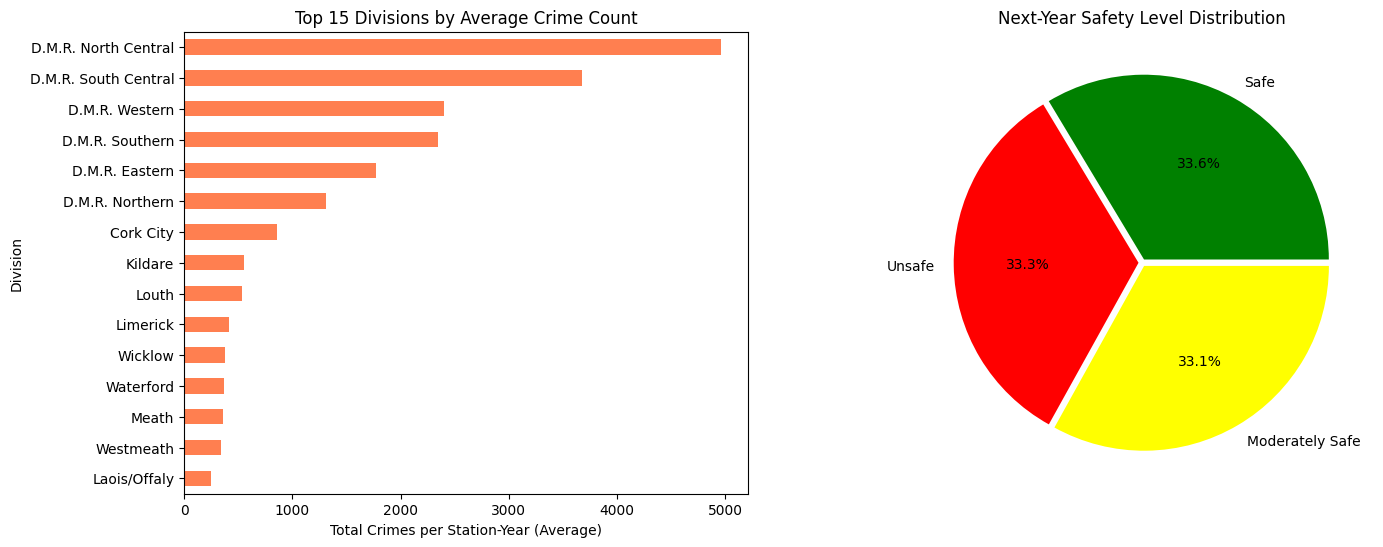

In [24]:
# Figure 1: Crime Rate Distribution by Division

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 divisions by average crime
div_crime = df_lagged.groupby('Division')['Total_Crime'].mean().sort_values(ascending=False)

ax1 = axes[0]
div_crime.head(15).plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Total Crimes per Station-Year (Average)')
ax1.set_title('Top 15 Divisions by Average Crime Count')
ax1.invert_yaxis()

# Safety Level Distribution
ax2 = axes[1]
colors = {'Safe': 'green', 'Moderately Safe': 'yellow', 'Unsafe': 'red'}
df_lagged['Safety_Level'].value_counts().plot(
    kind='pie', 
    ax=ax2, autopct='%1.1f%%', 
    colors=[colors[l] for l in df_lagged['Safety_Level'].value_counts().index],
    explode=(0.02, 0.02, 0.02)
)
ax2.set_title('Next-Year Safety Level Distribution')
ax2.set_ylabel('')

plt.show()

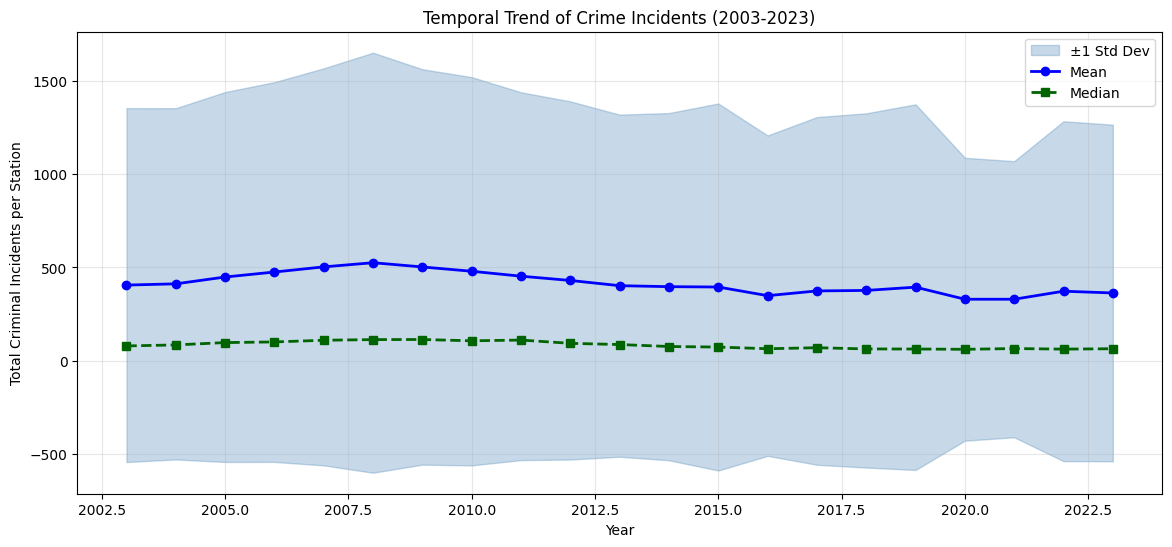

In [25]:
# Visual 2: Temporal Trends
fig, ax = plt.subplots(figsize=(14, 6))

yearly_crime = df_lagged.groupby('Year')['Total_Crime'].agg(['mean', 'median', 'std'])

ax.fill_between(yearly_crime.index, 
                yearly_crime['mean'] - yearly_crime['std'],
                yearly_crime['mean'] + yearly_crime['std'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')
ax.plot(yearly_crime.index, yearly_crime['mean'], 'o-', color='blue', linewidth=2, label='Mean')
ax.plot(yearly_crime.index, yearly_crime['median'], 's--', color='darkgreen', linewidth=2, label='Median')

ax.set_xlabel('Year')
ax.set_ylabel('Total Criminal Incidents per Station')
ax.set_title('Temporal Trend of Crime Incidents (2003-2023)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

Correlation Heatmap to understand how one type of offense can be linked to another type.

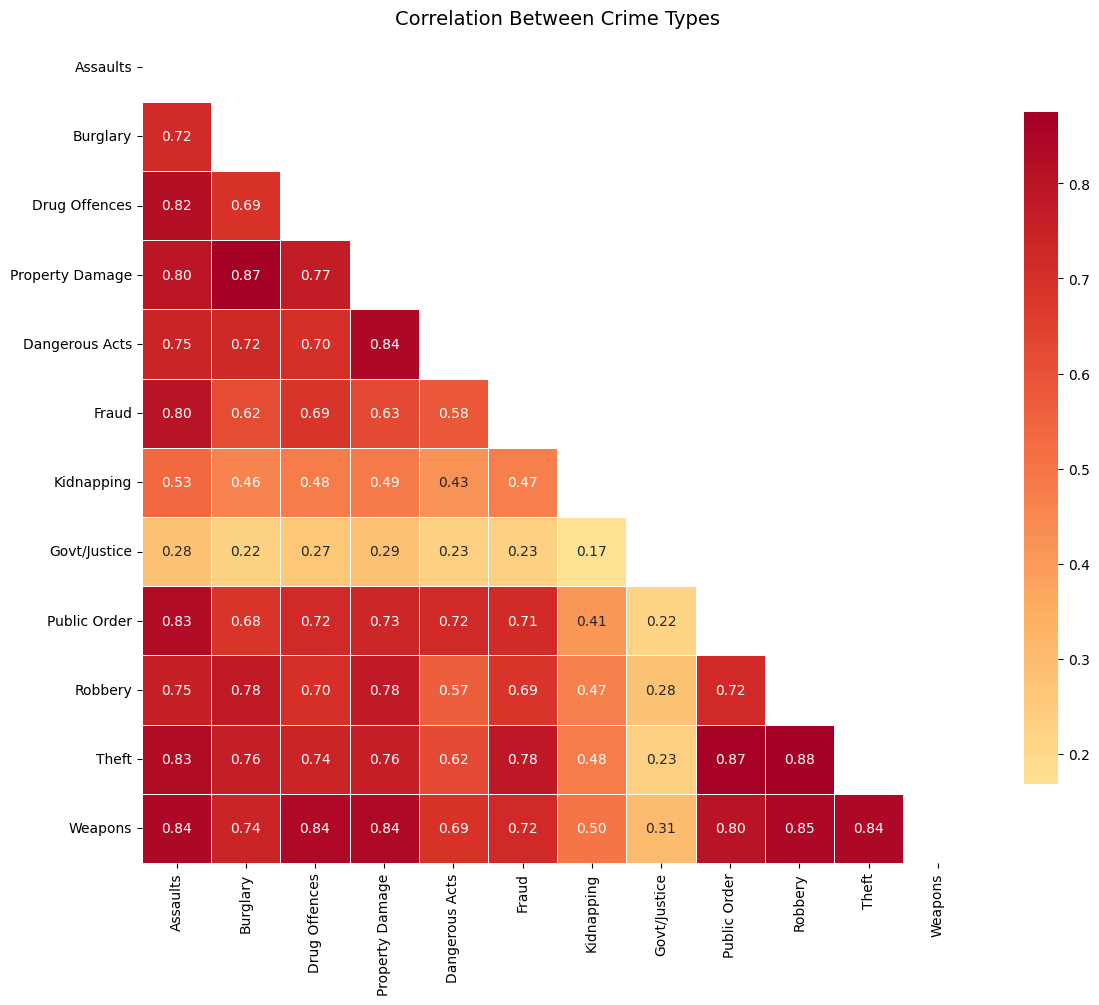

In [ ]:
# Visual 3: Correlation Heatmap
plt.figure(figsize=(12, 10))

short_names = {
    'Attempts/threats to murder, assaults, harassments and related offences': 'Assaults',
    'Dangerous or negligent acts': 'Dangerous Acts',
    'Kidnapping and related offences': 'Kidnapping',
    'Robbery, extortion and hijacking offences': 'Robbery',
    'Burglary and related offences': 'Burglary',
    'Theft and related offences': 'Theft',
    'Fraud, deception and related offences': 'Fraud',
    'Controlled drug offences': 'Drug Offences',
    'Weapons and explosives offences': 'Weapons',
    'Damage to property and to the environment  offences': 'Property Damage',
    'Public order and other social code offences': 'Public Order',
    'Offences against government, justice procedures and organisation of crime': 'Govt/Justice'
}

corr_data = df_lagged[offence_cols].copy()
corr_data.columns = [short_names.get(col, col) for col in corr_data.columns]

corr_matrix = corr_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Between Crime Types', fontsize=14)
plt.show()

**Model Creation**

In [ ]:
# Preparing features (current year) and target (next year safety)
X = df_lagged[offence_cols].copy()
y = df_lagged['Safety_Level']

# we used LabelEncoder to encode the target variable.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Features shape:", X.shape)
print("\nClass distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())
print("\nClass mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Features shape: (11844, 12)

Class distribution:
0    3916
1    3982
2    3946
Name: count, dtype: int64

Class mapping: {'Moderately Safe': np.int64(0), 'Safe': np.int64(1), 'Unsafe': np.int64(2)}


In [ ]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 9475 samples
Test set: 2369 samples


In [ ]:
# Decision Tree with RobustScaler
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ))
])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring='accuracy')
print("Accuracy values using 10-fold CV:", scores)
print("Mean Accuracy score: %.4f" % scores.mean())

Accuracy values using 10-fold CV: [0.87257384 0.85400844 0.86835443 0.8464135  0.85472973 0.8589527
 0.85641892 0.84797297 0.84290541 0.85304054]
Mean Accuracy score: 0.8555


In [ ]:
# Support Vector Machine (SVM) with RobustScaler
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', SVC(kernel='linear', C=1.0, random_state=42))
])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring='accuracy')
print("Accuracy values using 10-fold CV:", scores)
print("Mean Accuracy score: %.4f" % scores.mean())

Accuracy values using 10-fold CV: [0.88016878 0.88270042 0.88607595 0.87848101 0.87246622 0.87922297
 0.89611486 0.88851351 0.8910473  0.88597973]
Mean Accuracy score: 0.8841


In [ ]:
# Neural Network with RobustScaler
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100,64,64,32), 
        max_iter=500, 
        early_stopping=True,
        random_state=42,
        batch_size=64,
        learning_rate_init=0.001,
        alpha=0.0001
    ))
])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring='accuracy')
print("Accuracy values using 10-fold CV:", scores)
print("Mean Accuracy score: %.4f" % scores.mean())

Accuracy values using 10-fold CV: [0.88523207 0.88185654 0.89451477 0.86751055 0.87753378 0.87922297
 0.89611486 0.86993243 0.89189189 0.88006757]
Mean Accuracy score: 0.8824



FINAL EVALUATION ON TEST SET

SVC Classification Report:
                 precision    recall  f1-score   support

Moderately Safe       0.83      0.81      0.82       783
           Safe       0.86      0.88      0.87       797
         Unsafe       0.95      0.95      0.95       789

       accuracy                           0.88      2369
      macro avg       0.88      0.88      0.88      2369
   weighted avg       0.88      0.88      0.88      2369



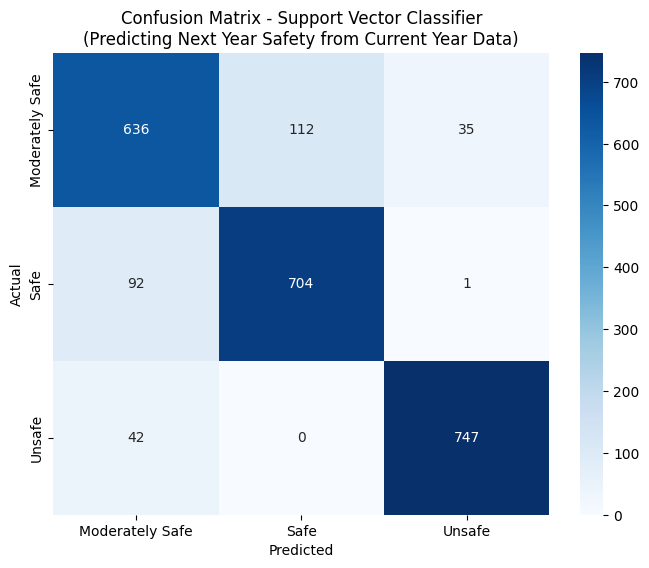

In [ ]:
# FINAL EVALUATION ON TEST SET

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVC Model
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("\nSVC Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Support Vector Classifier\n(Predicting Next Year Safety from Current Year Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4. Feature Selection

Identify which current-year crime types best predict next-year safety.

In [ ]:
# FEATURE SELECTION

# 1. SelectKBest
selector_kbest = SelectKBest(score_func=f_classif, k=5)
selector_kbest.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_kbest.scores_
}).sort_values('Score', ascending=False)

print("\n1. SelectKBest - Top Features:")
print(feature_scores.head().to_string(index=False))

# 2. RFE
rfe = RFE(
    estimator=DecisionTreeClassifier(random_state=42),
    n_features_to_select=5
)
rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.get_support(indices=True)].tolist()
print("\n2. RFE (Decision Tree) - Selected Features:")
for i, feat in enumerate(rfe_features, 1):
    print(f"   {i}. {feat}")

FEATURE SELECTION

1. SelectKBest - Top Features:
                                                               Feature       Score
                                           Dangerous or negligent acts 2488.432201
Attempts/threats to murder, assaults, harassments and related offences 2377.966560
                   Damage to property and to the environment  offences 2084.642231
                                         Burglary and related offences 1921.061707
                                              Controlled drug offences 1532.456350

2. RFE (Decision Tree) - Selected Features:
   1. Attempts/threats to murder, assaults, harassments and related offences
   2. Damage to property and to the environment  offences
   3. Dangerous or negligent acts
   4. Public order and other social code offences
   5. Theft and related offences


In [60]:
# Compare: All features vs Selected features


X_train_rfe = X_train.iloc[:, rfe.get_support(indices=True)]
X_test_rfe = X_test.iloc[:, rfe.get_support(indices=True)]

for name, model in [('Neural Network', MLPClassifier(hidden_layer_sizes=(100,64,64,32), max_iter=500, random_state=42)),
                    ('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42)),
                    ('SVM', SVC(kernel='linear', random_state=42))]:
    pipe_all = Pipeline([('scaler', RobustScaler()), ('model', model)])
    scores_all = cross_val_score(pipe_all, X_train, y_train, cv=cv, scoring='accuracy')
    
    pipe_rfe = Pipeline([('scaler', RobustScaler()), ('model', model)])
    scores_rfe = cross_val_score(pipe_rfe, X_train_rfe, y_train, cv=cv, scoring='accuracy')
    
    print(f"\n{name}:")
    print(f"  All features (12):  {scores_all.mean():.4f}")
    print(f"  RFE features (5):   {scores_rfe.mean():.4f}")


Neural Network:
  All features (12):  0.8523
  RFE features (5):   0.8711

Decision Tree:
  All features (12):  0.8551
  RFE features (5):   0.8519

SVM:
  All features (12):  0.8846
  RFE features (5):   0.8777


SelectKBest (ANOVA F-value): This univariate method ranks features based on their individual statistical relationship with the target variable. It is computationally efficient and provides a quick way to identify features with the strongest direct association to the outcome.
Recursive Feature Elimination (RFE): RFE is a wrapper method that recursively removes the least important features based on model performance (here, using a Decision Tree as the estimator). This approach considers feature interactions and can yield a more optimal subset for complex models.

After applying RFE to select the top 5 features, we compared the performance of three classifiers—Neural Network, Decision Tree, and SVM—using all features versus only the RFE-selected subset. The results, averaged over 5-fold cross-validation, showed that the reduction from 12 to 5 features led to only a marginal decrease in accuracy for all models.

This outcome highlights a key insight: a small subset of crime types (such as theft, burglary, and assaults) are highly indicative of future safety levels, while others contribute little additional information. This not only streamlines the modeling process but also provides actionable intelligence for policymakers, who can focus on the most impactful crime categories when designing interventions.

Advantages:

Simplicity: Models with fewer features are easier to interpret and maintain.
Efficiency: Reduced dimensionality speeds up training and inference.
Generalization: Eliminating noisy or irrelevant features can improve performance on unseen data.
Actionability: Identifying key predictors helps target resources and policy measures.
Limitations:

Potential Information Loss: Aggressive feature selection may discard variables that, while weak individually, are informative in combination.
Model Dependency: Wrapper methods like RFE are sensitive to the choice of estimator and may yield different subsets for different models.
Univariate Bias: Methods like SelectKBest ignore feature interactions, potentially overlooking important multivariate relationships

## 5. Future Prediction (Next Year's Safety)

In this final section, we use the trained Neural Network model to predict the **Next Year's Safety Level** for every Garda Station.
We use the *latest available year's crime data* for each station as the input features.

In [ ]:
# 1. Retrain Best Model on FULL Dataset (Neural Network)
print("Training final model on full historical dataset...")
final_model = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,64,64,32), max_iter=500, random_state=42))
])
final_model.fit(X, y_encoded)
print("Model trained successfully.")

# 2. Prepare Input Data for Prediction (Latest Year)
# We go back to 'df_pivot' which includes the last year (where Next_Year_Crime was NaN)
latest_data = df_pivot.sort_values('Year').groupby('Garda Station', as_index=False).last()
print(f"\nPredicting for {len(latest_data)} stations using data from year(s): {latest_data['Year'].unique()}")

# FIX: Calculate Division for latest_data because it might be missing in df_pivot
latest_data['Division'] = latest_data['Garda Station'].apply(
    lambda x: x.split(', ')[-1].replace(' Division', '') if ', ' in str(x) else 'Unknown'
)

X_future = latest_data[offence_cols]

# 3. Make Predictions
future_preds_encoded = final_model.predict(X_future)
future_preds_labels = le.inverse_transform(future_preds_encoded)

# 4. Create Results DataFrame
future_safety_report = pd.DataFrame({
    'Garda Station': latest_data['Garda Station'],
    'Division': latest_data['Division'],
    'Current_Year_Crime': latest_data['Total_Crime'],
    'Predicted_Next_Year_Safety': future_preds_labels
})

# Display Results
print("\n================================================")
print("PREDICTED SAFETY LEVELS FOR NEXT YEAR")
print("================================================")
print(future_safety_report['Predicted_Next_Year_Safety'].value_counts())

print("\nSample Predictions (Top Unsafe Predictions by Current Volume):")
print(future_safety_report[future_safety_report['Predicted_Next_Year_Safety'] == 'Unsafe']
      .sort_values('Current_Year_Crime', ascending=False).head(10).to_string(index=False))

print("\nSample Predictions (Safe Stations):")
print(future_safety_report[future_safety_report['Predicted_Next_Year_Safety'] == 'Safe']
      .head(5).to_string(index=False))

Training final model on full historical dataset...
Model trained successfully.

Predicting for 564 stations using data from year(s): [2024]

PREDICTED SAFETY LEVELS FOR NEXT YEAR
Predicted_Next_Year_Safety
Safe               232
Unsafe             167
Moderately Safe    165
Name: count, dtype: int64

Sample Predictions (Top Unsafe Predictions by Current Volume):
                                        Garda Station             Division  Current_Year_Crime Predicted_Next_Year_Safety
    62301 Store Street, D.M.R. North Central Division D.M.R. North Central             10711.0                     Unsafe
   61202 Pearse Street, D.M.R. South Central Division D.M.R. South Central              9753.0                     Unsafe
62101 Bridewell Dublin, D.M.R. North Central Division D.M.R. North Central              8110.0                     Unsafe
        66101 Blanchardstown, D.M.R. Western Division       D.M.R. Western              5006.0                     Unsafe
             64202 Tallag

In [63]:
future_safety_report['Predicted_Next_Year_Safety'].value_counts()

Predicted_Next_Year_Safety
Safe               232
Unsafe             167
Moderately Safe    165
Name: count, dtype: int64

In [ ]:
# 5. Export Predictions to Excel
import os

# Ensure reports directory exists
output_dir = '../reports'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'future_safety_predictions.xlsx')
future_safety_report.to_excel(output_path, index=False)
print(f"Predictions successfully saved to: {os.path.abspath(output_path)}")